# Lecture 5: Class demo

## Imports, Announcements, LOs

### Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join(os.path.abspath("../"), "code"))
from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

Do you recall [the restaurants survey](https://ubc.ca1.qualtrics.com/jfe/form/SV_73VuZiuwM1eDVrw) you completed at the start of the course?

Let's use that data for this demo. You'll find a [wrangled version](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/lectures/data/cleaned_restaurant_data.csv) in the course repository.

In [2]:
df = pd.read_csv('../data/cleaned_restaurant_data.csv')

In [3]:
df.describe()

,eat_out_freq,age,n_people,price
count,964.000000,964.000000,6.960000e+02,696.000000
mean,2.585187,23.975104,1.439254e+04,1472.179152
std,2.246486,4.556716,3.790481e+05,37903.575636
min,0.000000,10.000000,-2.000000e+00,0.000000
25%,1.000000,21.000000,1.000000e+01,18.000000
50%,2.000000,22.000000,2.000000e+01,25.000000
75%,3.000000,26.000000,3.000000e+01,40.000000
max,15.000000,46.000000,1.000000e+07,1000000.000000


Are there any unusual values in this data that you notice?
Let's get rid of these outliers. 

In [4]:
upperbound_price = 200
lowerbound_people = 1
df = df[~(df['price'] > 200)]
restaurant_df = df[~(df['n_people'] < lowerbound_people)]
restaurant_df.shape

(942, 11)

In [6]:
restaurant_df.describe()

,eat_out_freq,age,n_people,price
count,942.000000,942.000000,674.000000,674.000000
mean,2.598057,23.992569,24.973294,34.023279
std,2.257787,4.582570,22.016660,29.018622
min,0.000000,10.000000,1.000000,0.000000
25%,1.000000,21.000000,10.000000,18.000000
50%,2.000000,22.000000,20.000000,25.000000
75%,3.000000,26.000000,30.000000,40.000000
max,15.000000,46.000000,200.000000,200.000000


### Data splitting 

We want to predict whether a restaurant is a liked or disliked.

In [7]:
# Separate `X` and `y`. 

X = restaurant_df.drop(columns=['target'])
y = restaurant_df['target']

Below I'm perturbing this data just to demonstrate a few concepts. Don't do it in real life. 

In [8]:
X.at[459, 'food_type'] = 'Quebecois'
X['price'] = X['price'] * 100

In [9]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<br><br>

### EDA 

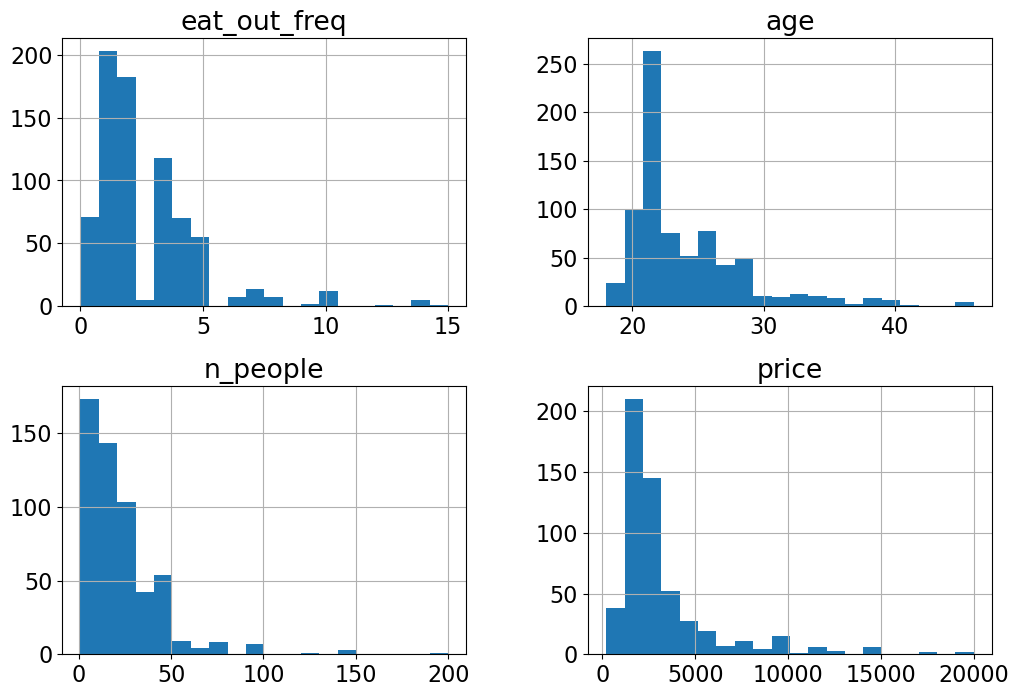

In [10]:
X_train.hist(bins=20, figsize=(12, 8));

Do you see any interesting things in the plots? 

In [11]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Thai                  20
Fusion                18
Mexican               17
fusion                 3
Quebecois              1
Name: count, dtype: int64

Error in data collection? Probably "Fusion" and "fusion" categories should be combined?

In [12]:
X_train['food_type'] = X_train['food_type'].replace("fusion", "Fusion")
X_test['food_type'] = X_test['food_type'].replace("fusion", "Fusion")

In [13]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

<br><br>

### Dummy Classifier

In [14]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002083,0.001355,0.516556,0.514950
1,0.001316,0.000704,0.516556,0.514950
2,0.000885,0.000568,0.516556,0.514950
3,0.000677,0.000497,0.513333,0.515755
4,0.001226,0.000986,0.513333,0.515755


We have a relatively balanced distribution of both 'like' and 'dislike' classes.

<br><br>

### Let's try KNN on this data

Do you think KNN would work directly on `X_train` and `y_train`?

In [15]:
# Preprocessing and pipeline
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)

We need to preprocess the data before passing it to ML models. What are the different types of features in the data? 

In [16]:
X_train.head()

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name
80,No,2.0,21,30.0,2200.0,Chinese,high,No,The environment was very not clean. The food tasted awful.,NaN
934,Yes,4.0,21,30.0,3000.0,Canadian/American,low,Yes,The building and the room gave a very comfy feeling. Immediately after sitting down it felt like we were right at home.,NaN
911,No,4.0,20,40.0,2500.0,Canadian/American,medium,Yes,I was hungry,Chambar
459,Yes,5.0,21,NaN,NaN,Quebecois,NaN,NaN,NaN,NaN
62,Yes,2.0,24,20.0,3000.0,Indian,high,Yes,bad taste,east is east


- What all transformations we need to apply before training a machine learning model? 
- Can we group features based on what type of transformations we would like to apply?

In [17]:
numeric_feats = [] # Continuous and quantitative features
categorical_feats = [] # Discrete and qualitative features
binary_feats = [] # Categorical features with only two possible values 
ordinal_feats = [] # Some natural ordering in the categories 
noise_cats = []
drop_feats = ['comments', 'restaurant_name'] # Let's drop them for now. 

In [21]:
numeric_feats = ['age', 'n_people', 'price'] # Continuous and quantitative features
categorical_feats = ['north_america', 'food_type'] # Discrete and qualitative features
binary_feats = ['good_server'] # Categorical features with only two possible values 
ordinal_feats = ['noise_level'] # Some natural ordering in the categories 
noise_cats = ['no music', 'low', 'medium', 'high', 'crazy loud']
drop_feats = ['comments', 'restaurant_name'] # Let's drop them for now. 

Let's begin with numeric features. What if we just use numeric features to train a KNN model? Would it work? 

In [22]:
knn.fit(X_train[numeric_feats], y_train)

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

We need to deal with NaN values. 

### sklearn's `SimpleImputer` 

In [23]:
from sklearn.impute import SimpleImputer

X_train_num = X_train[numeric_feats].values
imputer = SimpleImputer(strategy = "median")
imputer.fit(X_train_num)
X_train_num_imp = imputer.transform(X_train_num)
X_test_num_imp = imputer.transform(X_test[numeric_feats].values)

In [24]:
knn.fit(X_train_num_imp, y_train)

KNeighborsClassifier()

No more errors. It worked! Let's try cross validation. 

In [28]:
cross_val_score(knn, X_train_num_imp, y_train)

array([0.52980132, 0.52980132, 0.56953642, 0.51333333, 0.56666667])

We have slightly improved results in comparison to the dummy model. 

### Discussion questions 

- What's the difference between sklearn estimators and transformers?  
- Can you think of a better way to impute missing values? 

<br><br><br><br>

In [29]:
imp_pipe = make_pipeline(SimpleImputer(strategy = "median"), KNeighborsClassifier()) 
cross_val_score(imp_pipe, X_train_num, y_train)

array([0.52980132, 0.52980132, 0.56953642, 0.51333333, 0.56666667])

Do we need to scale the data? 

In [22]:
X_train[numeric_feats]

,age,n_people,price
80,21,30.0,2200.0
934,21,30.0,3000.0
911,20,40.0,2500.0
459,21,NaN,NaN
62,24,20.0,3000.0
...,...,...,...
106,27,10.0,1500.0
333,24,12.0,800.0
393,20,5.0,1500.0
376,20,NaN,NaN


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_num_imp)
X_train_num_imp_scaled = scaler.transform(X_train_num_imp)
X_test_num_imp_scaled = scaler.transform(X_test_num_imp)

### What are some alternative methods for scaling?
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Transform each feature to a desired range
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): Scale features using median and quantiles. Robust to outliers. 
- [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html): Works on rows rather than columns. Normalize examples individually to unit norm.
- [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html): A scaler that scales each feature by its maximum absolute value.
    - What would happen when you apply `StandardScaler` to sparse data?    
- You can also apply custom scaling on columns using [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). For example, when a column follows the power law distribution (a handful of your values have many data points whereas most other values have few data points) log scaling is helpful.    

- For now, let's focus on `StandardScaler`. Let's carry out cross-validation

In [31]:
cross_val_score(knn, X_train_num_imp_scaled, y_train)

array([0.55629139, 0.49006623, 0.56953642, 0.54      , 0.53333333])

In this case, we don't see a big difference with `StandardScaler`. But usually, scaling is a good idea. 

- This worked but are we doing anything wrong here? 
- What's the problem with calling `cross_val_score` with preprocessed data? 
- How would you do it properly?
<br><br><br><br>

In [32]:
# Code to create a pipeline 
pipe_knn = make_pipeline(SimpleImputer(strategy="median"), 
                         StandardScaler(), 
                         KNeighborsClassifier()
                        )
pipe_knn

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [33]:
cross_val_score(pipe_knn, X_train[numeric_feats], y_train)

array([0.56291391, 0.47019868, 0.52317881, 0.54      , 0.52666667])

- What all things are happening under the hood? 
- Why is this a better approach? 

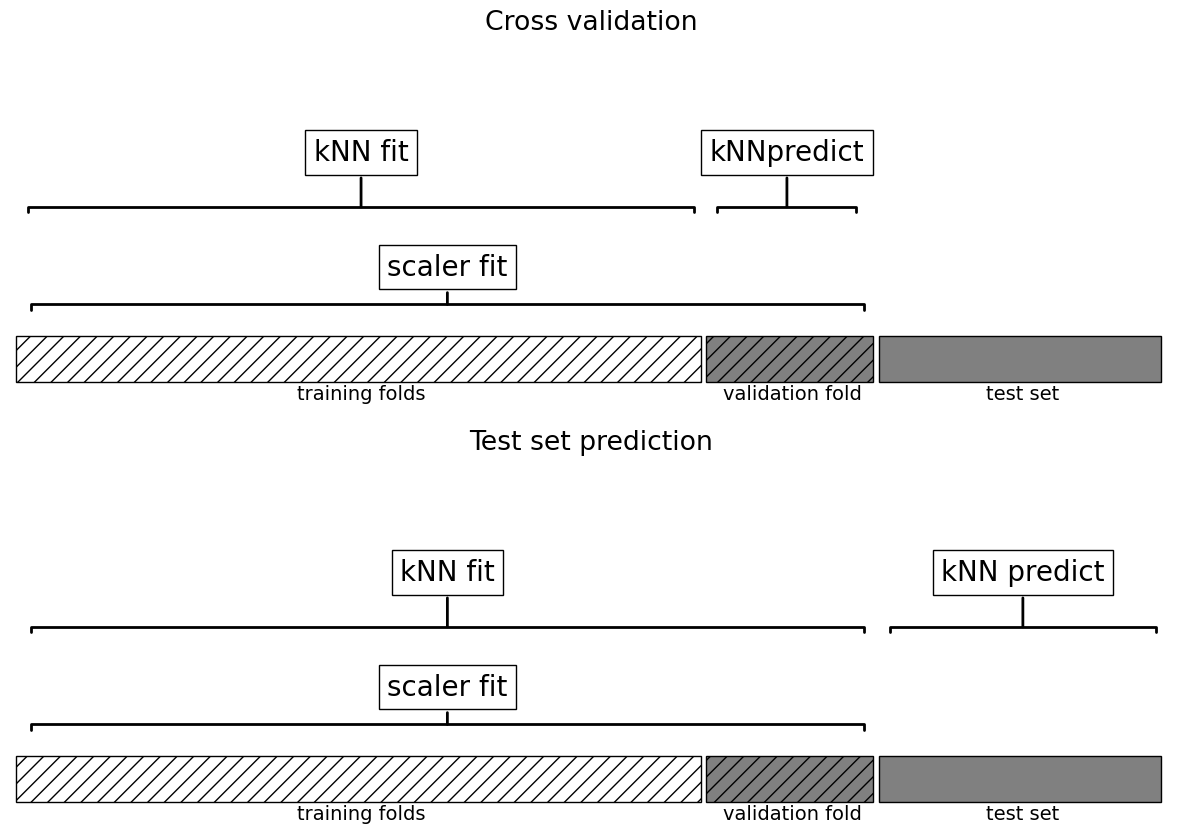

In [27]:
plot_improper_processing("kNN")

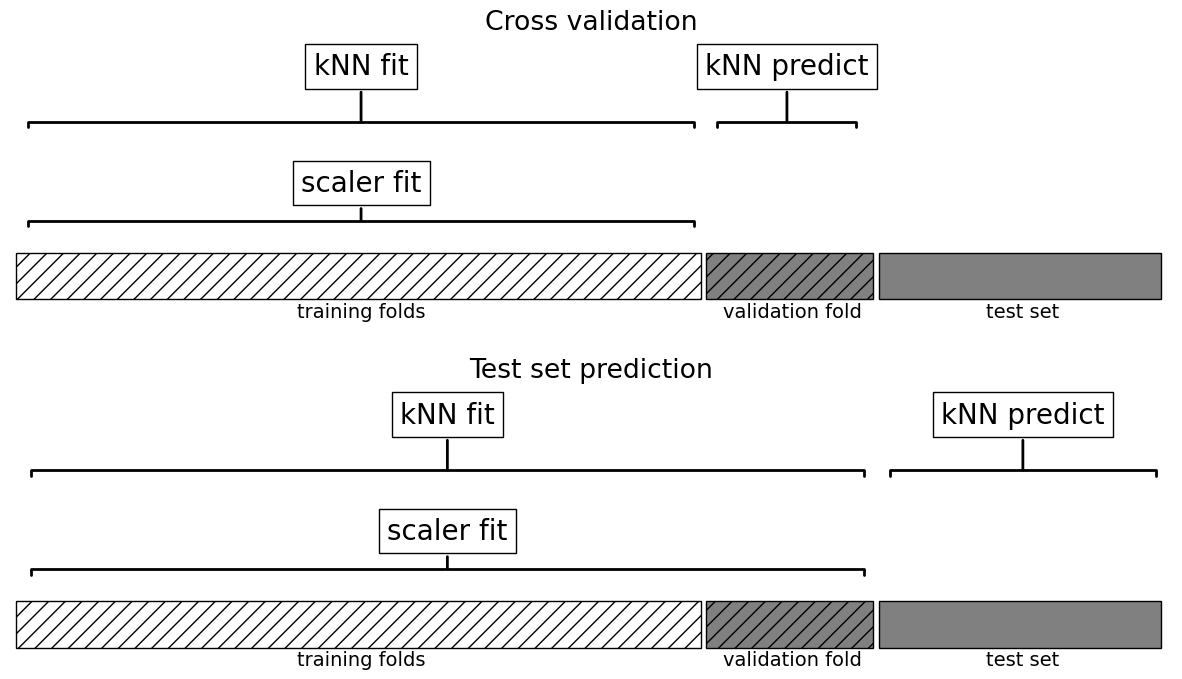

In [28]:
plot_proper_processing("kNN")

<br><br><br><br>

### Categorical features

Let's assess the scores using categorical features.

In [29]:
X_train[categorical_feats]

,north_america,food_type
80,No,Chinese
934,Yes,Canadian/American
911,No,Canadian/American
459,Yes,Quebecois
62,Yes,Indian
...,...,...
106,No,Chinese
333,No,Other
393,Yes,Canadian/American
376,Yes,NaN


In [30]:
X_train['north_america'].value_counts()

north_america
Yes                    415
No                     330
Don't want to share      8
Name: count, dtype: int64

In [31]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

In [32]:
X_train_cat = X_train[categorical_feats]
X_test_cat = X_test[categorical_feats]

In [33]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

In [34]:
X_train_ohe

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [35]:
ohe_feats = ohe.get_feature_names_out().tolist()

In [36]:
pd.DataFrame(X_train_ohe, columns = ohe_feats)

,north_america_Don't want to share,north_america_No,north_america_Yes,food_type_Canadian/American,food_type_Chinese,food_type_Fusion,food_type_Indian,food_type_Italian,food_type_Mexican,food_type_Other,food_type_Quebecois,food_type_Thai,food_type_nan
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
750,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


- It's a sparse matrix. 
- Why? What would happen if we pass `sparse=False`? Why we might want to do that? 

In [37]:
cross_val_score(knn, X_train_ohe, y_train)

array([0.53642384, 0.53642384, 0.50993377, 0.51333333, 0.47333333])

Are we breaking the golden rule here? Let's do this properly with a pipeline. 

In [38]:
# Code to create a pipeline for OHE and KNN

pipe_ohe_knn = make_pipeline(OneHotEncoder(), KNeighborsClassifier())

In [39]:
# cross_val_score(pipe_ohe_knn, X_train_cat, y_train)

- What's wrong here? 
- How can we fix this? 

In [40]:
# Fix the OHE

pipe_ohe_knn = make_pipeline(OneHotEncoder(handle_unknown="ignore"), KNeighborsClassifier())

In [41]:
cross_val_score(pipe_ohe_knn, X_train_cat, y_train)

array([0.56291391, 0.53642384, 0.56291391, 0.54666667, 0.56      ])

Right now we are working with numeric and categorical features separately. But ideally when we create a model, we need to use all these features together. 

Enter column transformer! In the next lecture we'll discuss column transformer. 

## Questions for class discussion 

Let's create some synthetic data. 

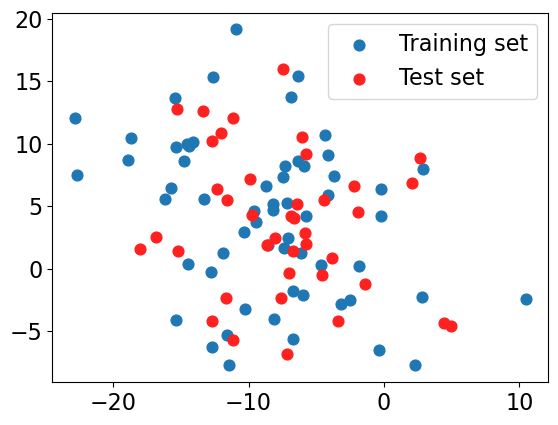

In [40]:
from sklearn.datasets import make_blobs, make_classification

# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=5)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.4)
plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], color=mglearn.cm2(1), label="Test set", s=60
)
plt.legend(loc="upper right");

Let's transform the data using `StandardScaler` and examine how the data looks like. 

In [41]:
scaler = StandardScaler()
train_transformed = scaler.fit_transform(X_train_toy)
test_transformed = scaler.transform(X_test_toy)

In [42]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std()

(-8.600287211119548, 6.2702469465199355)

In [43]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std()

(4.124686209266641, 6.2749592279985595)

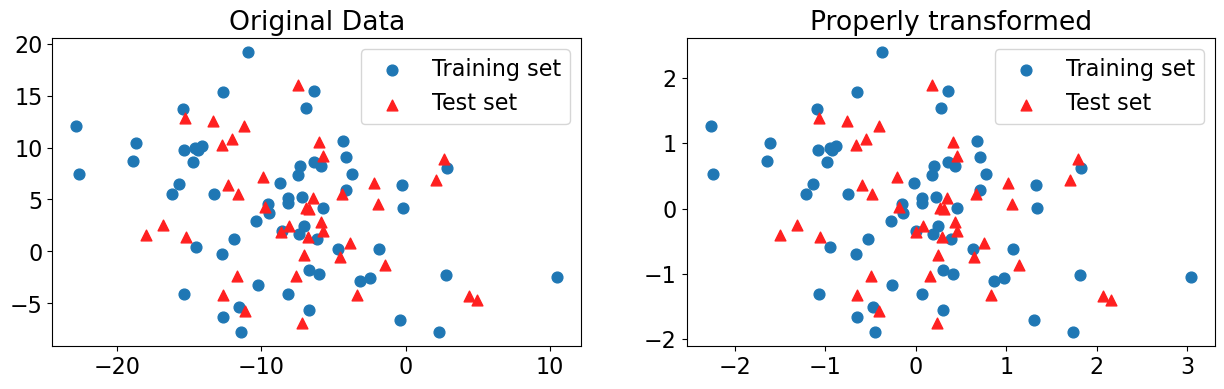

In [44]:
plot_original_scaled(X_train_toy, X_test_toy, train_transformed, test_transformed)

<br><br>

#### Bad methodology 1: Scaling the data separately (for class discussion)

In [45]:
# DO NOT DO THIS! For illustration purposes only.
scaler = StandardScaler()
scaler.fit(X_train_toy)
train_scaled = scaler.transform(X_train_toy)

scaler = StandardScaler()  # Creating a separate object for scaling test data
scaler.fit(X_test_toy)  # Calling fit on the test data
test_scaled = scaler.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data

knn = KNeighborsClassifier()
knn.fit(train_scaled, y_train_toy)
print(f"Training score: {knn.score(train_scaled, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_scaled, y_test_toy):.2f}")

Training score: 0.63
Test score: 0.60


- Is anything wrong in methodology 1? If yes, what is it?  
- What are the mean and standard deviation of columns in `X_train_toy` and `X_test_toy`?  

In [46]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

(-8.600287211119548, 6.2702469465199355)

In [47]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(4.124686209266641, 6.2749592279985595)

What are the mean and standard deviation of columns in `X_test_toy`?  

In [48]:
X_test_toy[:, 0].mean(), X_test_toy[:, 0].std() # mean and std of column 1 in X_test_toy

(-7.4360796317881865, 5.415791218175096)

In [49]:
X_test_toy[:, 1].mean(), X_test_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(3.584450392629585, 5.5947435906433025)

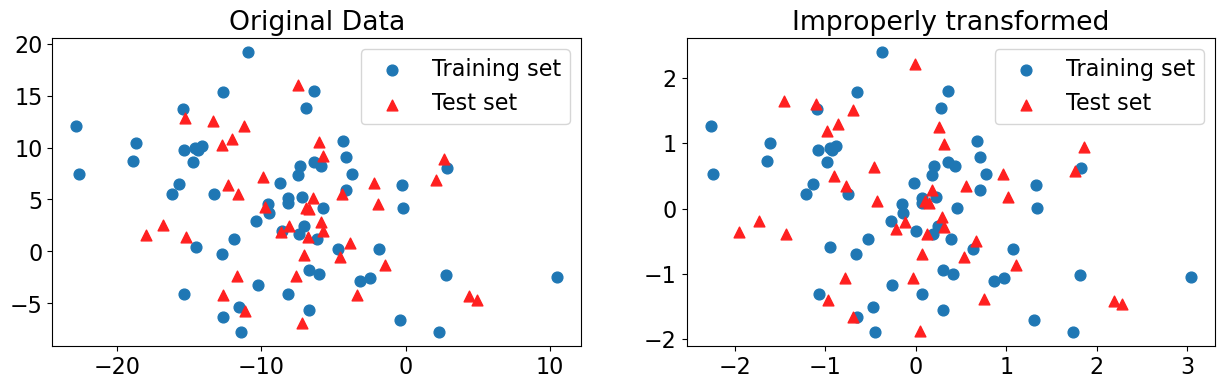

In [50]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    train_scaled,
    test_scaled,
    title_transformed="Improperly transformed",
)

<br><br>

#### Bad methodology 2: Scaling the data together (for class discussion)

In [51]:
X_train_toy.shape, X_test_toy.shape

((60, 2), (40, 2))

In [52]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

(100, 2)

In [53]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:X_train_toy.shape[0]]
XX_test = XX_scaled[X_train_toy.shape[0]:]

In [54]:
knn = KNeighborsClassifier()
knn.fit(XX_train, y_train_toy)
print(f"Training score: {knn.score(XX_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test_toy):.2f}")  # Misleading score

Training score: 0.63
Test score: 0.55


- Is anything wrong in methodology 2? If yes, what is it? 
- What's are the mean and std of `X_train_toy` vs. `XX`?

In [55]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

(-8.600287211119548, 6.2702469465199355)

In [56]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(4.124686209266641, 6.2749592279985595)

What are the mean and standard deviation of columns in `XX`?  

In [57]:
XX[:, 0].mean(), XX[:, 0].std() # mean and std of column 1 in XX

(-8.134604179387004, 5.970528192615454)

In [58]:
XX[:, 1].mean(), XX[:, 1].std() # mean and std of column 2 in XX

(3.9085918826118187, 6.017937808158447)

There is no big difference but they are not the same. 

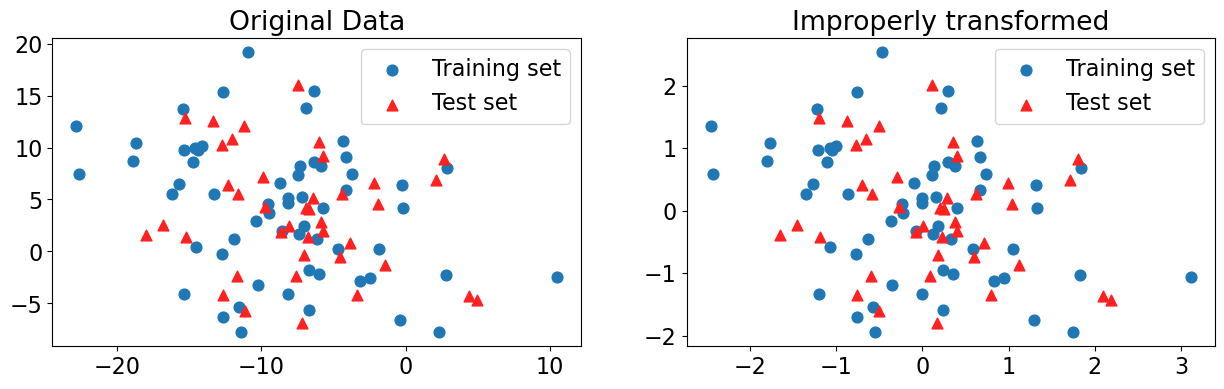

In [59]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    XX_train,
    XX_test,
    title_transformed="Improperly transformed",
)

Not a noticeable difference in the transformed data but if the test set is large it might influence the mean and standard deviation significantly. 

<br><br>

#### Methodology 3: Cross validation with already preprocessed data (for class discussion)

In [60]:
knn = KNeighborsClassifier()

scaler = StandardScaler()
scaler.fit(X_train_toy)
X_train_scaled = scaler.transform(X_train_toy)
X_test_scaled = scaler.transform(X_test_toy)
scores = cross_validate(knn, X_train_scaled, y_train_toy, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000456,0.001940,0.250000,0.687500
1,0.000322,0.001509,0.500000,0.625000
2,0.000335,0.000914,0.583333,0.541667
3,0.000331,0.000986,0.583333,0.604167
4,0.000295,0.000893,0.416667,0.604167


- Is there anything wrong in methodology 3? Are we breaking the golden rule here?  

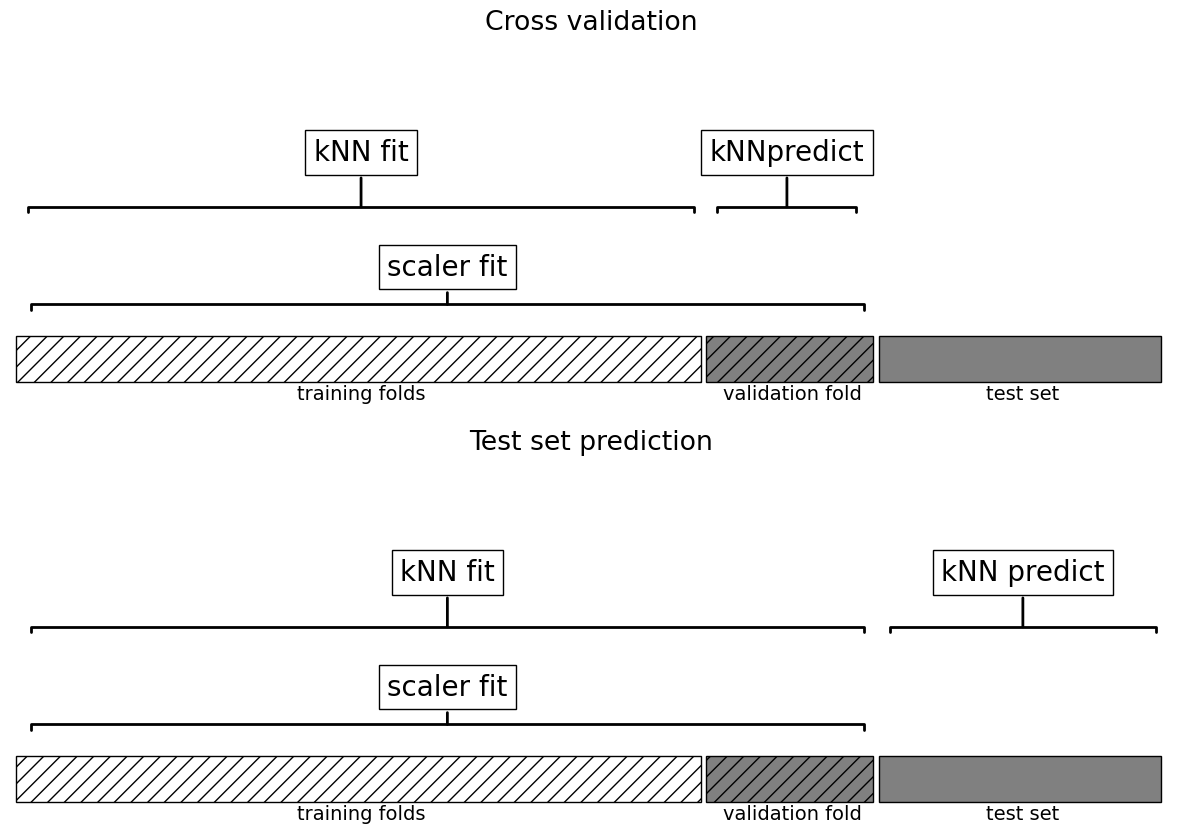

In [61]:
plot_improper_processing("kNN")

<br><br><br><br>

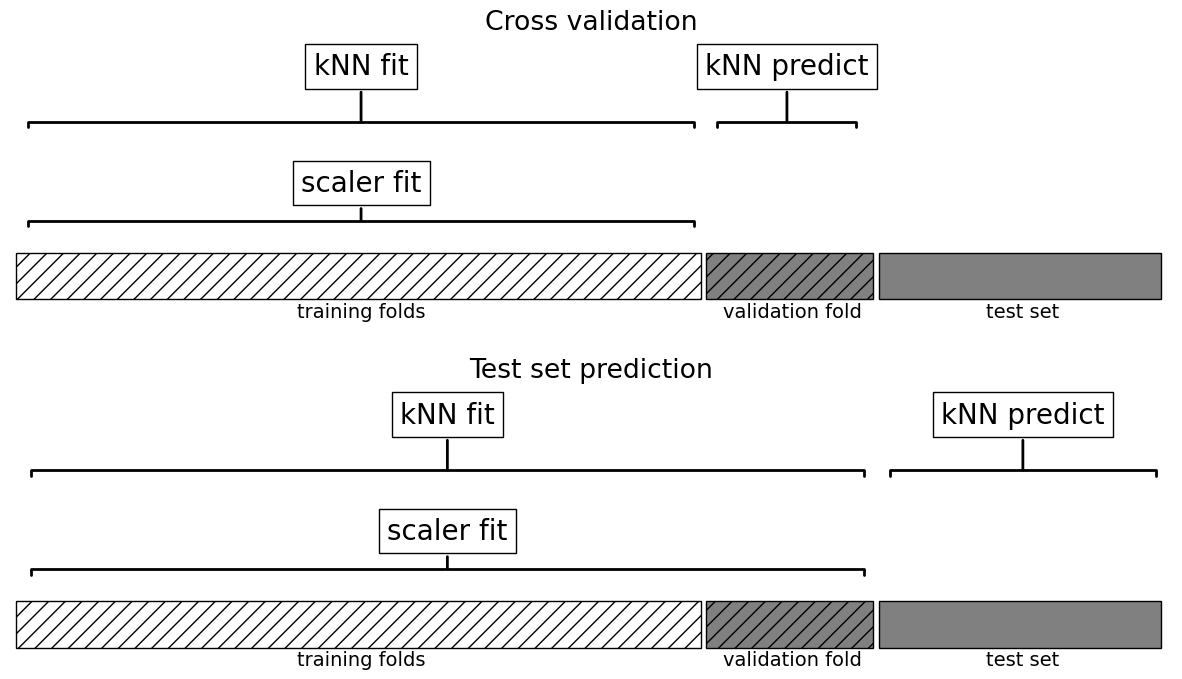

In [62]:
plot_proper_processing("kNN")

## Preprocessing mistakes

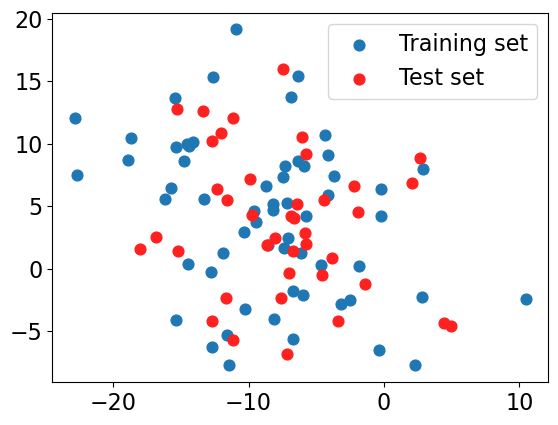

In [2]:
from sklearn.datasets import make_blobs, make_classification
# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=5)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.4)
plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], color=mglearn.cm2(1), label="Test set", s=60
)
plt.legend(loc="upper right")

In [5]:
import pandas as pd 

toy_spam = [
    [
        "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
        "spam",
    ],
    ["Lol you are always so convincing.", "non spam"],
    ["Nah I don't think he goes to usf, he lives around here though", "non spam"],
    [
        "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
        "spam",
    ],
    [
        "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
        "spam",
    ],
    ["Congrats! I can't wait to see you!!", "non spam"],
]
toy_df = pd.DataFrame(toy_spam, columns=["sms", "target"])
toy_df
X = toy_df.drop(columns=['target'])
y = toy_df['target']

In [8]:
from sklearn.model_selection import train_test_split
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(X, y, test_size=0.2, random_state=123)

#### Bad methodology 1: Vectorizing the data separately (for class discussion)

In [26]:
# DO NOT DO THIS! For illustration purposes only.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

vec_train = CountVectorizer(max_features = 10)
vec_train.fit(X_train_toy['sms'])
train_bow = vec_train.transform(X_train_toy['sms'])

vec_test = CountVectorizer(max_features = 10)  # Creating a separate object for scaling test data
vec_test.fit(X_test_toy)  # Calling fit on the test data
test_bow = vec_test.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data

# svm = SVC()
# svm.fit(train_bow, y_train_toy)
# print(f"Training score: {svm.score(train_bow, y_train_toy):.2f}")
# print(f"Test score: {svm.score(test_bow, y_test_toy):.2f}")

In [27]:
train_bow

<4x10 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

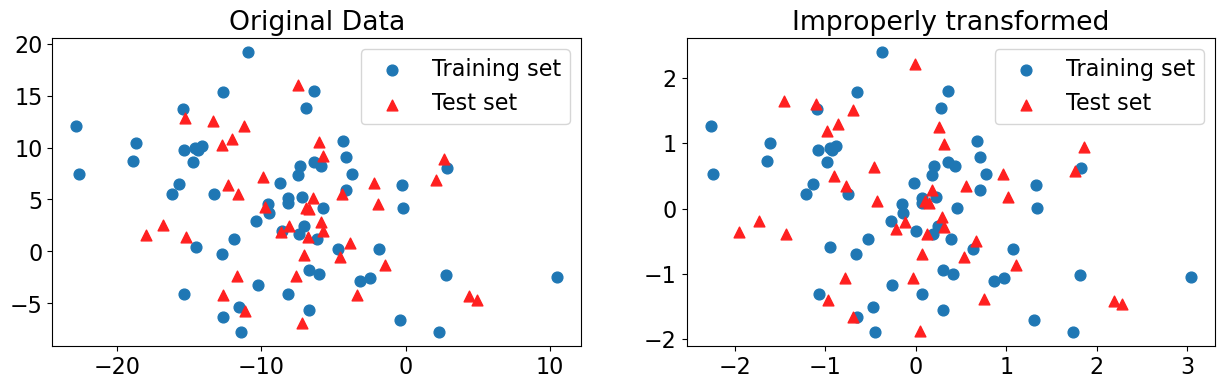

In [4]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    train_scaled,
    test_scaled,
    title_transformed="Improperly transformed",
)

#### Bad methodology 2: Scaling the data together (for class discussion)

In [5]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

(100, 2)

In [6]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:X_train_toy.shape[0]]
XX_test = XX_scaled[X_train_toy.shape[0]:]

In [7]:
knn = KNeighborsClassifier()
knn.fit(XX_train, y_train_toy)
print(f"Training score: {knn.score(XX_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test_toy):.2f}")  # Misleading score

Training score: 0.63
Test score: 0.55


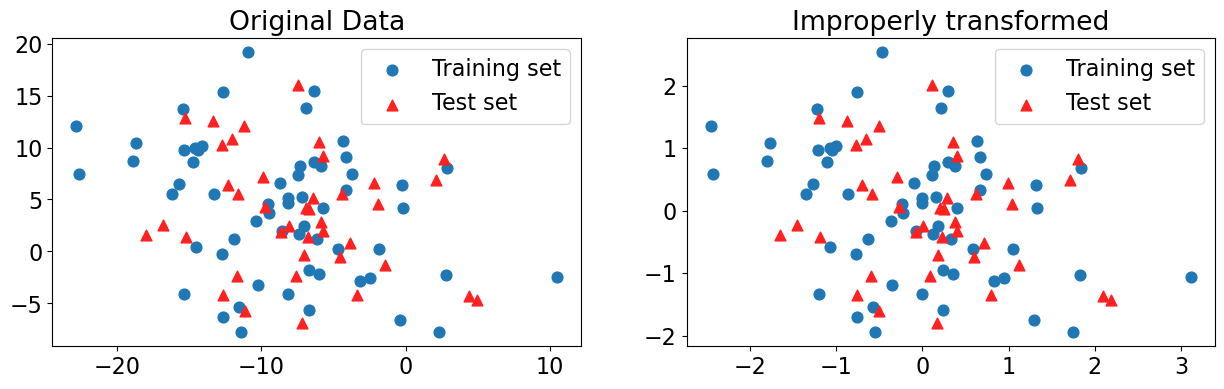

In [8]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    XX_train,
    XX_test,
    title_transformed="Improperly transformed",
)

In [9]:
XX_scaled[:, 0].mean(), XX_scaled[:, 0].std(), 

(-5.218048215738236e-16, 1.0)

In [10]:
XX_train[:, 0].mean(), XX_train[:, 0].std()

(-0.07799695717181604, 1.0501997049901186)

In [11]:
XX_test[:, 0].mean(), XX_test[:, 0].std()

(0.11699543575772282, 0.9070874541507946)

#### Bad methodology 3: Cross validation with already preprocessed data (for class discussion)

In [12]:
knn = KNeighborsClassifier()

scaler = StandardScaler()
scaler.fit(X_train_toy)
X_train_scaled = scaler.transform(X_train_toy)
X_test_scaled = scaler.transform(X_test_toy)
scores = cross_validate(knn, X_train_scaled, y_train_toy, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000505,0.001228,0.250000,0.687500
1,0.000334,0.001098,0.500000,0.625000
2,0.000276,0.000836,0.583333,0.541667
3,0.000282,0.000865,0.583333,0.604167
4,0.000251,0.000802,0.416667,0.604167


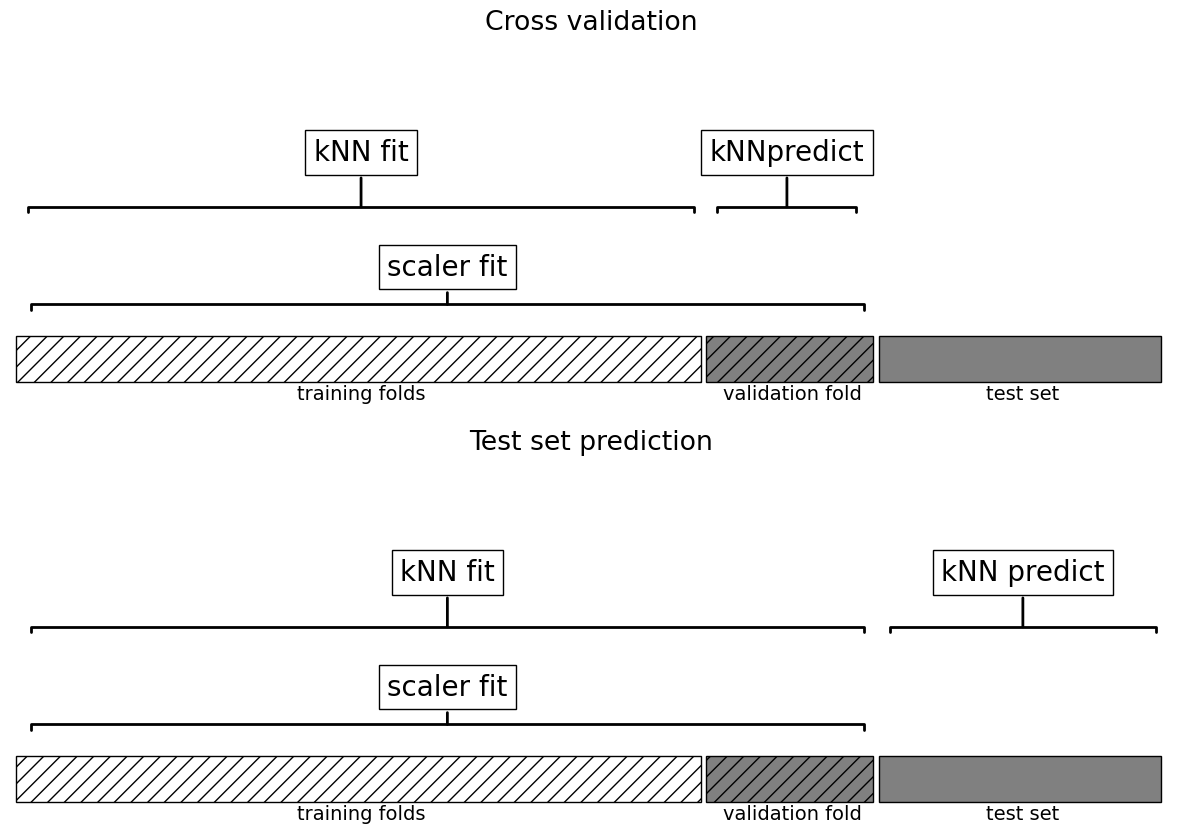

In [13]:
plot_improper_processing("kNN")

In [84]:
toy_spam = [
    [
        "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
        "spam",
    ],
    ["Lol you are always so convincing.", "non spam"],
    ["Nah I don't think he goes to usf, he lives around here though", "non spam"],
    [
        "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
        "spam",
    ],
    [
        "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
        "spam",
    ],
    ["Congrats! I can't wait to see you!!", "non spam"],
]
toy_df = pd.DataFrame(toy_spam, columns=["sms", "target"])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
text_feat = ['comments']
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), numeric_feats),
    (make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(drop="if_binary")), binary_feats),    
    (make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)), categorical_feats),
    (make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), reshape_for_countvectorizer, CountVectorizer(stop_words="english")), text_feat)
)

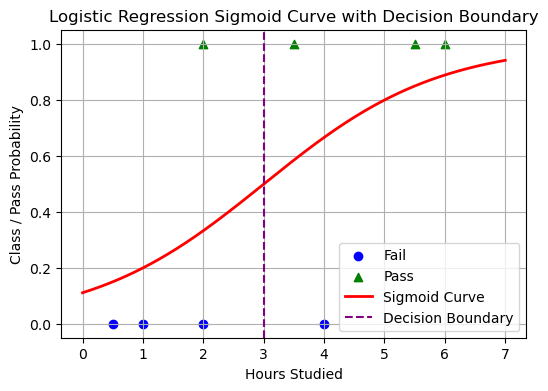

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Given data
hours_studied = np.array([0.5, 1.0, 2.0, 2.0, 3.5, 4.0, 5.5, 6.0])
target = np.array(["fail", "fail", "pass", "fail", "pass", "fail", "pass", "pass"])

# Convert target labels to binary (0 for fail, 1 for pass)
target_binary = np.where(target == "pass", 1, 0)

# Reshape hours_studied into a 2D array
X = hours_studied.reshape(-1, 1)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X, target_binary)

# Generate prediction probabilities
x_values = np.linspace(0, 7, 1000)  # Values for x-axis
y_values = model.predict_proba(x_values.reshape(-1, 1))[:, 1]  # Probabilities for pass

# Separate data points by class for coloring
pass_points = hours_studied[target_binary == 1]
fail_points = hours_studied[target_binary == 0]

# Plot the sigmoid curve and decision boundary
plt.figure(figsize=(6, 4))
plt.scatter(fail_points, np.zeros_like(fail_points), color='blue', label='Fail', marker='o')
plt.scatter(pass_points, np.ones_like(pass_points), color='green', label='Pass', marker='^')
plt.plot(x_values, y_values, color='red', label='Sigmoid Curve', linewidth=2)
decision_boundary = -model.intercept_ / model.coef_[0]  # Calculate the decision boundary
plt.axvline(x=decision_boundary, color='purple', linestyle='--', label='Decision Boundary')
plt.xlabel('Hours Studied')
plt.ylabel('Class / Pass Probability')
plt.title('Logistic Regression Sigmoid Curve with Decision Boundary')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [5]:
model.predict_proba(X)

array([[0.85035069, 0.14964931],
       [0.80075444, 0.19924556],
       [0.66781975, 0.33218025],
       [0.66781975, 0.33218025],
       [0.41564598, 0.58435402],
       [0.33469833, 0.66530167],
       [0.15109678, 0.84890322],
       [0.1118122 , 0.8881878 ]])